<a href="https://colab.research.google.com/github/jbaquerot/Master-Data-Science-UV-2019/blob/master/FairML_PreprocesingData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LUCA Challenge, GMV BDA team proposal

## Analysis and mitigation of bias in machine learning

The two main topics of interest are, first, the detection of bias in a dataset, as when machine learning algorithms learn, they learn from data, and if the data is biased, we expect the algorithm to be biased aswell, thus becoming susceptible of making discriminatory predictions. Second, we want to be able to mitigate that bias in the case that we detect it so that we can still use the power of machine learning to aid in the decision making process.

We are going to demonstrate these two topics in action over an example. We chose to analyze an open dataset from the spanish **Instituto Nacional de Estadística** that has data about salaries in Spain. It is well known that there is a gap in salaries between male and female employees. We start by showing that this is in fact the case and that the proposed metrics detect it, then we proceed to train a model on this data and show that the algorithm has learned the bias in the dataset and makes discriminatory predictions. We finish by showing a way to train a model that performs just slightly worse but makes fairer predictions, thus mitigating, at least in part, the discrimination.

## Imports

In [0]:
import os
import sys

import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from IPython.display import IFrame

np.random.seed(0)
pd.options.mode.chained_assignment = None

## Brief description of the data

The original dataset consist of 54 variables and 216769 observations. We have removed some of the attributes that are not relevant for our purposes and calculated the net salary with the formula SALBASE+COMSAL+EXTRAORM+PHEXTRA-COTIZA-IRPFMES to make our response variable 'SALNETO'. 

The attribute that we are looking to protect from discrimination is 'SEXO' which encodes the gender information as 6 for females and 1 for males. 

- Data: Encuestas de Estructura Salarial
- Source: [Instituto Nacional de Estadística](http://www.ine.es/dyngs/INEbase/es/operacion.htm?c=Estadistica_C&cid=1254736177025&menu=resultados&secc=1254736195110&idp=1254735976596)

## Preparation

This section is devoted to present the data and its pre-processing. 

In [2]:
!wget ftp://www.ine.es/temas/salarial/datos_2010.zip

--2019-10-18 07:39:41--  ftp://www.ine.es/temas/salarial/datos_2010.zip
           => ‘datos_2010.zip’
Resolving www.ine.es (www.ine.es)... 195.254.149.130, 195.254.149.129
Connecting to www.ine.es (www.ine.es)|195.254.149.130|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /temas/salarial ... done.
==> SIZE datos_2010.zip ... 47900756
==> PASV ... done.    ==> RETR datos_2010.zip ... done.
Length: 47900756 (46M) (unauthoritative)

datos_2010.zip      100%[===================>]  45.68M  7.01MB/s    in 12s     

2019-10-18 07:39:54 (3.97 MB/s) - ‘datos_2010.zip’ saved [47900756]



In [3]:
!unzip -o datos_2010.zip

Archive:  datos_2010.zip
   creating: CSV/
  inflating: CSV/EES_2010.csv        
  inflating: dr_EES_2010.xlsx        
  inflating: Leeme.txt               
  inflating: md_EES_2010.txt         
   creating: R/
  inflating: R/LeemeR.txt            
  inflating: R/MD_EES_2010.R         
   creating: SAS/
  inflating: SAS/ees_2010.sas7bdat   
  inflating: SAS/EES_2010_conFormato.sas  
   creating: SPSS/
  inflating: SPSS/EES_2010.sav       
   creating: STATA/
  inflating: STATA/EES_2010.dta      
  inflating: Obtenciвn de los resultados publicados a partir de los microdatos.doc  


In [4]:
# Read the data
data_raw = pd.read_csv("./CSV/EES_2010.csv", delimiter="\t", quotechar="\"" )
print('Observations: ' + str(data_raw.shape[0]))
print('Number of features: ' + str(data_raw.shape[1]))
data_raw.head()

Observations: 216769
Number of features: 54


,ORDENCCC,ORDENTRA,NUTS1,CNACE,ESTRATO2,CONTROL,MERCADO,REGULACION,SEXO,TIPOPAIS,CNO1,RESPONSA,ESTU,ANOANTI,MESANTI,TIPOJOR,TIPOCON,FIJODISM,FIJODISD,VAL,VAN,PUENTES,JAP,JSP1,JSP2,HEXTRA,DRELABM,SIESPM1,DSIESPM1,SIESPM2,DSIESPM2,SALBASE,EXTRAORM,PHEXTRA,COMSAL,COMSALTT,IRPFMES,COTIZA,BASE,DRELABAM,DRELABAD,SIESPA1,DSIESPA1,SIESPA2,DSIESPA2,SIESPA3,DSIESPA3,SIESPA4,DSIESPA4,SALBRUTO,GEXTRA,VESP,ANOS2,FACTOTAL
0,15000013,1,1,D0,1,2,1,3,6,1,E0,1,2,37,9,2,2,0,0,0,30,0,312,6,0,0,31,6,0,6,0,123.62,0.0,0.0,184.63,0.0,0.00,17.74,279.28,12,0,6,0,6,0,6,0,6,0,4420.14,404.83,0.0,6,16.96
1,15000013,2,1,D0,1,2,1,3,1,1,E0,1,4,35,9,1,1,0,0,0,30,0,1800,40,0,0,31,6,0,6,0,824.11,0.0,0.0,1066.76,0.0,277.90,131.14,2065.05,12,0,6,0,6,0,6,0,6,0,27437.38,4956.12,0.0,5,16.96
2,15000013,3,1,D0,1,2,1,3,1,1,L0,0,1,36,9,2,2,0,0,0,30,0,312,6,0,0,31,6,0,6,0,122.87,0.0,0.0,238.38,0.0,0.00,19.33,304.55,12,0,6,0,6,0,6,0,6,0,5630.07,384.73,0.0,6,16.96
3,15000013,4,1,D0,1,2,1,3,1,1,N0,0,1,33,0,1,1,0,0,0,30,0,1800,40,0,0,31,6,0,6,0,821.17,0.0,0.0,382.76,0.0,84.28,88.75,1397.74,12,0,6,0,6,0,6,0,6,0,17799.44,3303.86,0.0,5,16.96
4,15000013,5,1,D0,1,2,1,3,1,1,N0,0,1,1,0,1,1,0,0,0,30,0,1800,40,0,0,31,6,0,6,0,1039.66,0.0,0.0,137.60,0.0,117.73,69.36,1092.43,12,0,6,0,6,0,6,0,6,0,14588.46,0.00,0.0,4,16.96


We have removed some of the attributes that are not relevant for our purposes and calculated the net salary with the formula SALBASE+COMSAL+EXTRAORM+PHEXTRA-COTIZA-IRPFMES to make our response variable 'SALNETO'

In [0]:
 #SALBASE+COMSAL+EXTRAORM+PHEXTRA-COTIZA-IRPFMES
data_raw['SALNETO']= data_raw.SALBASE + data_raw.COMSAL + data_raw.EXTRAORM + data_raw.PHEXTRA - data_raw.COTIZA - data_raw.IRPFMES
data = data_raw.drop(["ORDENCCC",
                      "ORDENTRA",
                      "FACTOTAL",
                      "SALBASE",
                      "EXTRAORM",
                      "PHEXTRA",
                      "COMSAL",
                      "COMSALTT",
                      "IRPFMES",
                      "COTIZA",
                      "BASE",
                      "SALBRUTO",
                      "GEXTRA",
                      "VESP"], axis= 1)

In [6]:
data.columns

Index(['NUTS1', 'CNACE', 'ESTRATO2', 'CONTROL', 'MERCADO', 'REGULACION',
       'SEXO', 'TIPOPAIS', 'CNO1', 'RESPONSA', 'ESTU', 'ANOANTI', 'MESANTI',
       'TIPOJOR', 'TIPOCON', 'FIJODISM', 'FIJODISD', 'VAL', 'VAN', 'PUENTES',
       'JAP', 'JSP1', 'JSP2', 'HEXTRA', 'DRELABM', 'SIESPM1', 'DSIESPM1',
       'SIESPM2', 'DSIESPM2', 'DRELABAM', 'DRELABAD', 'SIESPA1', 'DSIESPA1',
       'SIESPA2', 'DSIESPA2', 'SIESPA3', 'DSIESPA3', 'SIESPA4', 'DSIESPA4',
       'ANOS2', 'SALNETO'],
      dtype='object')

We obtain both net salary distributions per genre with the aim of visualize the effects that this attribute can cause in the salary that people perceive. We can see in the graph below that the mean of the female distribution is clearly lower compared to the male one. Moreover, the higher net salary, the lower amount of female wage-earners. So, we can conclude that the female genre is the unprivileged group, as we expected.

In [7]:
# Run
IFrame('https://public.tableau.com/views/CmpDistSalnetoGenINE2010/Dashboard2?:showVizHome=no&amp;:embed=true ', width='100%',height=600) 

Before start working with the dataset, we combine the columns JSP1 and JSP2, which refer to working hours and minutes respectively, generating a new column JSP. As we have several categorical variables, we encode them using one hot encoding.

In [0]:
data["JSP"] = data["JSP1"] + data["JSP2"]/60
data = data.drop(["JSP1","JSP2"], axis=1)

# OneHotEncoding for categorical variables
categorical_cols = ["NUTS1", "CNACE", "ESTRATO2", "CONTROL", "MERCADO", "REGULACION", "TIPOPAIS","CNO1","RESPONSA","ESTU",
                    "TIPOJOR","TIPOCON","SIESPM1","SIESPM2","SIESPA1", "SIESPA2", "SIESPA3", "SIESPA4"]

for i in categorical_cols:    
    one_hot = pd.get_dummies(data[i])
    data = data.drop(i, axis=1)
    data = pd.merge(data, one_hot, left_index=True, right_index=True)

Then, we split our data into train and test sets ensuring that both of them keep the gender proportion.
###### Observation
It is worth noting that it exists a naive approach to the bias mitigation problem, which consists of removing the protected attribute from the dataset in the hopes of eliminating the discrimination. The approach is based on the idea that if the model does not consider the attribute that we are trying to protect, then the model wont discriminate based on that attribute. However, this approach to the problem is not enough, as there might, and with very high probability are, other variables strongly correlated with the one that we want to protect from discrimination, often called proxy variables. Our approach must therefore be different; furthermore, we will always consider datasets for which the protected attribute has been removed to show that our approach does not dependent on that.


Finally, we categorize our response variable 'SALNETO' by using a threshold. If the salary is greater than a this threshold it is encoded as 1, and 0 otherwise. We decided to set a meaningful threshold like 1000€, quantity often used for discriminating between a low salary and a high one in Spain.

In [0]:
# Split the data into training and test sets. (0.75, 0.25) split.
#train, test = train_test_split(data, stratify=data["SEXO"])
train, test = train_test_split(data, stratify=data["SEXO"], train_size= 0.3)

train_x = train.drop(["SALNETO", "SEXO"], axis=1)
test_x = test.drop(["SALNETO", "SEXO"], axis=1)
train_y = train[["SALNETO", "SEXO"]]
test_y = test[["SALNETO", "SEXO"]]

In [0]:
#Salary categorization
thr = 1000

train_y.loc[train_y['SALNETO'] <= thr, 'SALNETO'] = 0
train_y.loc[train_y['SALNETO'] > thr, 'SALNETO'] = 1

test_y.loc[test_y['SALNETO'] <= thr, 'SALNETO'] = 0
test_y.loc[test_y['SALNETO'] > thr, 'SALNETO'] = 1

## Metrics
Before starting our fairness analysis, we need to define a set of metrics related to how we measure fairness. Fortunately, metrics like this have already been collected and included in the AIF360 toolkit from IBM. We will use their definitions, briefly explained below. For a more in depth explanation we recommend to refer to the source.

_Source:_ [AI Fairness 360](https://aif360.mybluemix.net/)

#### Statistical Parity Difference:

Computed as the difference of the rate of favorable outcomes received by the unprivileged group to the privileged group.

- The ideal value of this metric is 0
- Fairness for this metric is between -0.1 and 0.1

In [0]:
def statistical_parity_difference(data, protected_col, protected_val, unprotected_val, Class):
    fav_outcome_rate_unpriv = len(data[(data[Class] == 1) & (data[protected_col] == protected_val)]) /\
                              len(data[data[protected_col] == protected_val])
    fav_outcome_rate_priv = len(data[(data[Class] == 1) & (data[protected_col] == unprotected_val)]) /\
                            len(data[data[protected_col] == unprotected_val])
    return(fav_outcome_rate_unpriv - fav_outcome_rate_priv)

In [12]:
spd_pre_orig = statistical_parity_difference(train_y, 'SEXO', 6, 1, 'SALNETO')
print(spd_pre_orig)

-0.20783865345804953


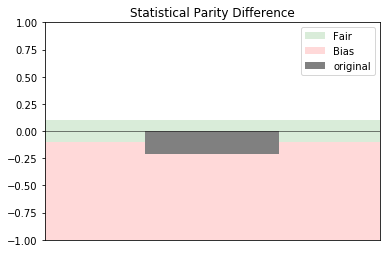

In [13]:
import matplotlib.pyplot as plt
plt.figure()
plt.ylim([-1, 1])
plt.xlim([-1, 1])
plt.axhspan(-0.1, 0.1, facecolor='green', alpha=0.15, label='Fair')
plt.axhspan(-1, -0.1, facecolor='red', alpha=0.15, label='Bias')
plt.bar(0, spd_pre_orig, align='center', label='original', color='grey')
plt.axhline(y=0, color='black', lw=0.5)
plt.xticks([])
plt.title('Statistical Parity Difference')
plt.legend()
plt.show()

#### Disparate impact

Computed as the ratio of rate of favorable outcome for the unprivileged group to that of the privileged group.

- The ideal value of this metric is 1.0 A value < 1 implies higher benefit for the privileged group and a value >1 implies a higher benefit for the unprivileged group.
- Fairness for this metric is between 0.8 and 1.2.

In [0]:
def disparate_impact(data, protected_col, protected_val, unprotected_val, Class):
    fav_outcome_rate_unpriv = len(data[(data[Class] == 1) & (data[protected_col] == protected_val)]) /\
                              len(data[data[protected_col] == protected_val])
    fav_outcome_rate_priv = len(data[(data[Class] == 1) & (data[protected_col] == unprotected_val)]) /\
                            len(data[data[protected_col] == unprotected_val])
    return(fav_outcome_rate_unpriv / fav_outcome_rate_priv)

In [15]:
di_pre_orig = disparate_impact(train_y, 'SEXO', 6,1,'SALNETO')
print(di_pre_orig)

0.7427020447395961


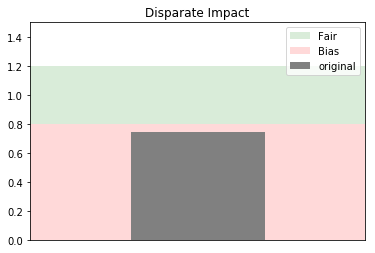

In [16]:
plt.figure()
plt.ylim([0, 1.5])
plt.xlim([-1, 1])
plt.axhspan(0.8, 1.2, facecolor='green', alpha=0.15, label='Fair')
plt.axhspan(0, 0.8, facecolor='red', alpha=0.15, label='Bias')
plt.bar(0, di_pre_orig, align='center', label='original', color='grey')
plt.xticks([])
plt.title('Disparate Impact')
plt.legend()
plt.show()

As shown by the metrics above, the dataset is biased concerning the gender information.
 

**[Below metrics will be used after the modeling stage]** 

#### Equal Opportunity Difference

This metric is computed as the difference of true positive rates between the unprivileged and the privileged groups. The true positive rate is the ratio of true positives to the total number of actual positives for a given group.

- The ideal value is 0. A value of < 0 implies higher benefit for the privileged group and a value > 0 implies higher benefit for the unprivileged group.
- Fairness for this metric is between -0.1 and 0.1.

In [0]:
def equal_opportunity_difference(data, protected_col, protected_val, unprotected_val, Class, pClass):
    tpr_unpriv = len(data[(data[Class] == 1) & (data[pClass] == 1) & (data[protected_col] == protected_val)]) /\
                 len(data[(data[Class] == 1) & (data[protected_col] == protected_val)])
    tpr_priv = len(data[(data[Class] == 1) & (data[pClass] == 1) & (data[protected_col] == unprotected_val)]) / \
               len(data[(data[Class] == 1) & (data[protected_col] == unprotected_val)])
    return(tpr_unpriv - tpr_priv)

#### Average Odds Difference

Computed as average difference of false positive rate (false positives / negatives) and true positive rate (true positives / positives) between unprivileged and privileged groups.

- The ideal value of this metric is 0. A value of < 0 implies higher benefit for the privileged group and a value > 0 implies higher benefit for the unprivileged group.
- Fairness for this metric is between -0.1 and 0.1.

In [0]:
def average_odds_difference(data, protected_col, protected_val, unprotected_val, Class, pClass):
    tpr_unpriv = len(data[(data[Class] == 1) & (data[pClass] == 1) & (data[protected_col] == protected_val)]) / \
                 len(data[(data[Class] == 1) & (data[protected_col] == protected_val)])
    tpr_priv = len(data[(data[Class] == 1) & (data[pClass] == 1) & (data[protected_col] == unprotected_val)]) / \
               len(data[(data[Class] == 1) & (data[protected_col] == unprotected_val)])
    fpr_unpriv = len(data[(data[Class] == 0) & (data[pClass] == 1) & (data[protected_col] == protected_val)]) / \
                 len(data[(data[Class] == 0) & (data[protected_col] == protected_val)])
    fpr_priv = len(data[(data[Class] == 0) & (data[pClass] == 1) & (data[protected_col] == unprotected_val)]) / \
               len(data[(data[Class] == 0) & (data[protected_col] == unprotected_val)])
    unpriv_mean = np.mean([tpr_unpriv, fpr_unpriv])
    priv_mean = np.mean([tpr_priv, fpr_priv])
    return(unpriv_mean - priv_mean)

## Modeling
It is time now to train a classifier with the pre-processed dataset. Remember that the protected attribute has been removed and no bias mitigation technique has been applied so far.

**Classifier:** Random Forest

**Parameters:**
- Number of trees in the forest: 100
- Maximum depth of the tree: Cross-validated via GridSearch

In [19]:
rfc = RandomForestClassifier(n_estimators= 100)
param_grid = {'max_depth' : np.arange(30,65,5)}
#param_grid = {'max_depth' : np.arange(10,65,5)}
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
CV_rfc.fit(train_x, train_y['SALNETO'])

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid='w

In [20]:
CV_rfc.best_params_

{'max_depth': 50}

In [21]:
rfc1=RandomForestClassifier(random_state=42, 
                           max_features= 'auto', 
                           max_depth = CV_rfc.best_params_['max_depth'], 
                           n_estimators= 100, 
                           criterion='gini')

rfc1.fit(train_x, train_y['SALNETO'])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=50, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [0]:
# Evaluate metrics
def eval_metrics(actual, pred):
    acc = np.mean(accuracy_score(actual, pred))
    bal_acc = balanced_accuracy_score(actual, pred)
    return acc, bal_acc

In [23]:
# Testing the classifer
predicted_salary = rfc1.predict(test_x)

predicted_y = pd.DataFrame(predicted_salary)
(acc, bal_acc) = eval_metrics(test_y['SALNETO'], predicted_salary)


print("Random Forest (n_estimators=%i, max_depth=%i):" % (100, CV_rfc.best_params_['max_depth']))
print("  Accuracy: %s" % acc)
print("  Balanced Accuracy: %s" % bal_acc)

Random Forest (n_estimators=100, max_depth=50):
  Accuracy: 0.8689460191513059
  Balanced Accuracy: 0.8045029431409887


In [0]:
# Save model
import pickle
filename = 'rf_model.sav'
pickle.dump(rfc1, open(filename, 'wb'))

## Metrics after the model

We now proceed to calculate the metrics described above but on the predictions made by the model.

Remember that the protected attribute was removed from the dataset!

In [0]:
test_y['predicted'] = predicted_salary

In [26]:
spd_orig = statistical_parity_difference(test_y, 'SEXO', 6, 1, 'predicted')
print(spd_orig)

-0.19463360110770167


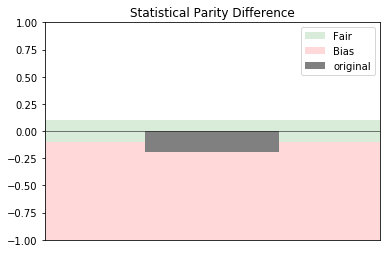

In [27]:
import matplotlib.pyplot as plt
plt.figure()
plt.ylim([-1, 1])
plt.xlim([-1, 1])
plt.axhspan(-0.1, 0.1, facecolor='green', alpha=0.15, label='Fair')
plt.axhspan(-1, -0.1, facecolor='red', alpha=0.15, label='Bias')
plt.bar(0, spd_orig, align='center', label='original', color='grey')
plt.axhline(y=0, color='black', lw=0.5)
plt.xticks([])
plt.title('Statistical Parity Difference')
plt.legend()
plt.show()

In [28]:
di_orig = disparate_impact(test_y, 'SEXO', 6, 1, 'predicted')
print(di_orig)

0.7747270981335973


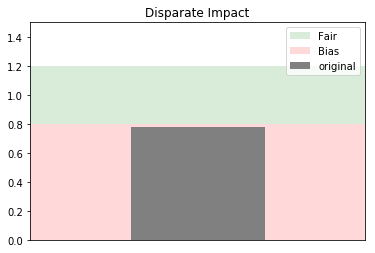

In [29]:
plt.figure()
plt.ylim([0, 1.5])
plt.xlim([-1, 1])
plt.axhspan(0.8, 1.2, facecolor='green', alpha=0.15, label='Fair')
plt.axhspan(0, 0.8, facecolor='red', alpha=0.15, label='Bias')
plt.bar(0, di_orig, align='center', label='original', color='grey')
plt.xticks([])
plt.title('Disparate Impact')
plt.legend()
plt.show()

In [30]:
eod_orig = equal_opportunity_difference(test_y,'SEXO', 6, 1,'SALNETO', 'predicted')
print(eod_orig)

-0.03449446640138787


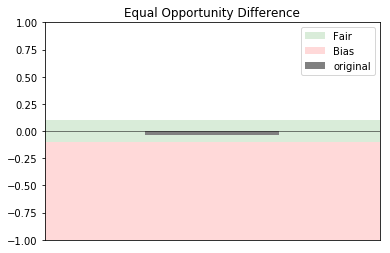

In [31]:
plt.figure()
plt.ylim([-1, 1])
plt.xlim([-1, 1])
plt.axhspan(-0.1, 0.1, facecolor='green', alpha=0.15, label='Fair')
plt.axhspan(-1, -0.1, facecolor='red', alpha=0.15, label='Bias')
plt.bar(0, eod_orig, align='center', label='original', color='grey')
plt.axhline(y=0, color='black', lw=0.5)
plt.xticks([])
plt.title('Equal Opportunity Difference')
plt.legend()
plt.show()

In [32]:
aod_orig = average_odds_difference(test_y, 'SEXO', 6, 1, 'SALNETO', 'predicted')
print(aod_orig)

-0.09823008980490078


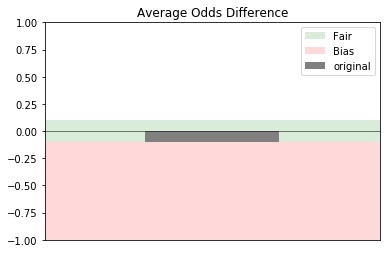

In [33]:
plt.figure()
plt.ylim([-1, 1])
plt.xlim([-1, 1])
plt.axhspan(-0.1, 0.1, facecolor='green', alpha=0.15, label='Fair')
plt.axhspan(-1, -0.1, facecolor='red', alpha=0.15, label='Bias')
plt.bar(0, aod_orig, align='center', label='original', color='grey')
plt.axhline(y=0, color='black', lw=0.5)
plt.xticks([])
plt.title('Average Odds Difference')
plt.legend()
plt.show()

2 out of 4 metrics show that the model has learnt the bias present in the data and is making discriminatory predictions.

## Bias Mitigation using Uniform Sampling

Here we implement a method for bias mitigation called uniform sampling, proposed in the paper below. The idea is to calculate a set of weighs that would make the dataset fairer. Then we upsample the classes with weigh greater than 1 and downsample the rest. This has a very natural interpretation:

In our example we have seen that we have more females with low salaries than men. The strategy is to:
- upsample (weighs > 1): females with high income and males with low income
- downsample (weighs < 1): males with high income and females with low income

By doing this we are trying to balance the dataset in terms of fairness and thus helping mitigate the bias.

_Source:_ [Kamiran, F., & Calders, T. (2012). Data preprocessing techniques for classification without discrimination. Knowledge and Information Systems, 33(1), 1-33.](https://link.springer.com/article/10.1007/s10115-011-0463-8)

In [0]:
def get_weighs(df, protected_col, protected_val, unprotected_val, Class):
    '''Obtain the weighs by means of the reweigh method.
    input:
        df: pandas DataFrame object
        protected_col: colum with the protected attribute
        protected_val: protected attribute label
        Class: name of the column with the coded classes as 
               1 (favorable), 0 (unfavorable)
    otput:
        weighs values dictionary'''
    
    p_protected = sum(df[protected_col] == protected_val)/len(df)
    p_class = sum(df[Class] == 1)/len(df)
    
    at1 = df[df[protected_col] == protected_val]
    at2 = df[df[protected_col] == unprotected_val]
    sb = sum(at1[Class] == 1)
    sd = sum(at2[Class] == 1)
    p_observed = sb/len(df)
    p_observed2 = sd/len(df)
    
    res_P_F = (p_protected * p_class)/p_observed
    res_P_D = (p_protected * (1-p_class))/((len(at1)/len(df))-p_observed)
    res_NP_F = ((1-p_protected) * p_class)/p_observed2
    res_NP_D = ((1-p_protected) * (1-p_class))/((len(at2)/len(df))-p_observed2)
    return({'protegido_fav':res_P_F,'protegido_desf':res_P_D,'nprotegido_fav':res_NP_F,'nprotegido_desf':res_NP_D})

In [0]:
def mk_US_df(df,protected_col, protected_val,unprotected_val, Class):
    '''Resample the different subsets of data using uniform sampling.
    input:
        df: pandas DataFrame object
        protected_col: colum with the protected attribute
        protected_val: protected attribute label
        unprotected_val: unprotected attribute label
        Class: name of the column with the coded classes as 
               1 (favorable), 0 (unfavorable)
    otput:
        resampled pandas DataFrame object'''
    weighs = get_weighs(df,protected_col, protected_val,unprotected_val, Class)
    DP = df.loc[(df[protected_col] == protected_val) & (df[Class] == 1)]
    DN = df.loc[(df[protected_col] == protected_val) & (df[Class] == 0)]
    FP = df.loc[(df[protected_col] == unprotected_val) & (df[Class] == 1)]
    FN = df.loc[(df[protected_col] == unprotected_val) & (df[Class] == 0)]
    ssize_DP = round(weighs['protegido_fav'] * len(DP))
    ssize_DN = round(weighs['protegido_desf'] * len(DN))
    ssize_FP = round(weighs['nprotegido_fav'] * len(FP))
    ssize_FN = round(weighs['nprotegido_desf'] * len(FN))
    df_1 = DP.sample(n=ssize_DP, replace = True, random_state = 1)
    df_2 = DN.sample(n=ssize_DN, replace = True, random_state = 1)
    df_3 = FP.sample(n=ssize_FP, replace = True, random_state = 1)
    df_4 = FN.sample(n=ssize_FN, replace = True, random_state = 1)
    frames = [df_1,df_2,df_3,df_4]
    df = pd.concat(frames)
    return(df)

In [36]:
train_data = train_x
train_data['SEXO'] = train_y['SEXO']
train_data['SALNETO'] = train_y['SALNETO']

transformed_data = mk_US_df(train_data,'SEXO', 6, 1, 'SALNETO')
transformed_data.head()

,ANOANTI,MESANTI,FIJODISM,FIJODISD,VAL,VAN,PUENTES,JAP,HEXTRA,DRELABM,DSIESPM1,DSIESPM2,DRELABAM,DRELABAD,DSIESPA1,DSIESPA2,DSIESPA3,DSIESPA4,ANOS2,JSP,1_x,2_x,3_x,4_x,5_x,6_x,7_x,B0_x,C1,C2,C3,C4,C5,C6,C7,C8,D0_x,E0_x,F0_x,G1,...,E0_y,F0_y,G0,H0,I0_y,J0_y,K0_y,L0_y,M0_y,N0_y,O0_y,P0_y,0_y,1_x,1_y,2_x,3,4,5,6_y,7_y,8,1_x,2_y,1_y,2,1_x,6_x,1_y,6_y,1_x,6_x,1_y,6_y,1_x,6_x,1_y,6_y,SEXO,SALNETO
159291,9,6,0,0,0,31,0,1769,0,31,0,0,12,0,0,0,0,0,3,40.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,1,0,0,1,0,1,0,1,0,1,0,1,0,1,6,1.0
34824,9,4,0,0,0,30,0,1800,0,31,0,0,12,0,0,0,0,0,3,40.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,1,0,1,0,1,0,1,0,1,6,1.0
140415,5,4,0,0,0,30,0,1426,0,31,0,0,12,0,19,0,0,1,3,31.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,1,0,1,0,1,1,0,0,1,0,1,1,0,6,1.0
79684,9,9,0,0,0,30,3,1700,0,31,0,0,12,0,0,0,0,0,3,37.5,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,1,0,0,1,0,1,0,1,0,1,0,1,0,1,6,1.0
93433,6,10,0,0,0,30,2,1840,0,31,0,0,12,0,0,0,0,0,3,40.0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,1,0,1,0,1,0,1,0,1,0,1,6,1.0


In [0]:
train_transformed_y = transformed_data[["SALNETO","SEXO"]]
train_transformed_x = transformed_data.drop(["SALNETO", "SEXO"], axis=1)

**Now, we propose another way to make the oversampling based on the [SMOTE](https://www.jair.org/index.php/jair/article/view/10302) generation method.**

Basically, we select a random sample of the desired subset and calculate its K nearest neighbours. Then, we randomly select one of these nearest neighbours and generate a synthetic sample between them. The processed is repeated to obtain the desired number of synthetic samples.

In [0]:
from scipy.spatial import distance
import random

def knn_generate(df, k, Ns, protected_col, protected_val, Class, label):
    '''Generate synthetic data by means of the k-NN method.
    input:
        df: pandas DataFrame object
        k: number of nearest neighbour
        protected_col: colum with the protected attribute
        protected_val: protected attribute label
        Class: name of the column with the coded classes as 
               1 (favorable), 0 (unfavorable)
        label: 1 (favorable), 0 (unfavorable)
    otput:
        resampled pandas DataFrame object'''
    N = len(df)
    for i in range(Ns):
        rand_idx = random.randint(0, N)
        sample_i = df.iloc[rand_idx]
        euclidean_distances = df.apply(lambda row: distance.euclidean(row, sample_i), axis=1)
        distance_frame = pd.DataFrame(data={"dist": euclidean_distances, "idx": euclidean_distances.index})
        distance_frame.sort_values(by="dist", inplace=True)
        knn = distance_frame.iloc[0:k+1]["idx"]
        knn_samples = df.loc[knn]
        rand_nn = random.randint(1,k)
        mean_sample = knn_samples.iloc[[0,rand_nn]].mean(axis=0)
        df = df.append(mean_sample, ignore_index=True)
    df[protected_col] == protected_val
    df[Class] = label
    return(df)

In [0]:
def mk_knnS_df(df,protected_col, protected_val,unprotected_val, Class):
    '''Resample the different subsets of data using knn method
    for oversampling.
    input:
        df: pandas DataFrame object
        protected_col: colum with the protected attribute
        protected_val: protected attribute label
        unprotected_val: unprotected attribute label
        Class: name of the column with the coded classes as 
               1 (favorable), 0 (unfavorable)
    otput:
        resampled pandas DataFrame object'''
    
    weighs = get_weighs(df,protected_col, protected_val,unprotected_val, Class)
    DP = df.loc[(df[protected_col] == protected_val) & (df[Class] == 1)]
    DN = df.loc[(df[protected_col] == protected_val) & (df[Class] == 0)]
    FP = df.loc[(df[protected_col] == unprotected_val) & (df[Class] == 1)]
    FN = df.loc[(df[protected_col] == unprotected_val) & (df[Class] == 0)]
    ssize_DP = round(weighs['protegido_fav'] * len(DP))
    ssize_DN = round(weighs['protegido_desf'] * len(DN))
    ssize_FP = round(weighs['nprotegido_fav'] * len(FP))
    ssize_FN = round(weighs['nprotegido_desf'] * len(FN))
    df_2 = DN.sample(n=ssize_DN, replace = True, random_state = 1)
    df_3 = FP.sample(n=ssize_FP, replace = True, random_state = 1)
    
    df_1 = knn_generate(DP, 3, ssize_DP - len(DP), protected_col, protected_val, Class, 1)
    df_4 = knn_generate(FN, 3, ssize_FN - len(FN), protected_col, unprotected_val, Class, 0)

    frames = [df_1,df_2,df_3,df_4]
    df = pd.concat(frames)
    return(df)

In [0]:
# Data can be calculated with the methods above, but we will load it as we have already obtained it
transformed_knn_data = mk_knnS_df(train_data,'SEXO', 6, 1, 'SALNETO')
# transformed_knn_data = pd.read_csv('transformed_data.csv', sep=';', encoding='utf-8') 

train_transformed_knn_y = transformed_knn_data[["SALNETO","SEXO"]]
train_transformed_knn_x = transformed_knn_data.drop(["SALNETO", "SEXO"], axis=1)

### Comparison of metrics before applying the model

As we have said, our bias mitigation method is based on achieving a fairer, less biased dataset to train a model on. Here we present our results compared to those obtained before the bias mitigation. Later we retrain our model on this dataset and discuss the results.

In [41]:
spd_pre_us = statistical_parity_difference(train_transformed_y, 'SEXO', 6, 1, 'SALNETO')
print(spd_pre_us)

spd_pre_us_knn = statistical_parity_difference(train_transformed_knn_y, 'SEXO', 6, 1, 'SALNETO')
print(spd_pre_us_knn)

1.0237104572596856e-05
1.0237104572596856e-05


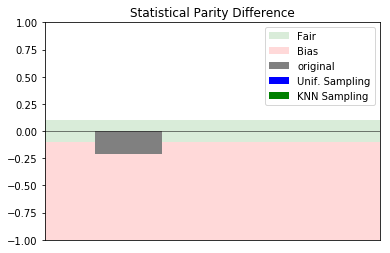

In [42]:
import matplotlib.pyplot as plt
plt.figure()
plt.ylim([-1, 1])
plt.xlim([-1, 3])
plt.axhspan(-0.1, 0.1, facecolor='green', alpha=0.15, label='Fair')
plt.axhspan(-1, -0.1, facecolor='red', alpha=0.15, label='Bias')
plt.bar(0, spd_pre_orig, align='center', label='original', color='grey')
plt.bar(1, spd_pre_us, align='center', label='Unif. Sampling', color='blue')
plt.bar(2, spd_pre_us_knn, align='center', label='KNN Sampling', color='green')
plt.axhline(y=0, color='black', lw=0.5)
plt.xticks([])
plt.title('Statistical Parity Difference')
plt.legend()
plt.show()

In [43]:
di_pre_us = disparate_impact(train_transformed_y, 'SEXO', 6, 1, 'SALNETO')
print(di_pre_us)

di_pre_us_knn = disparate_impact(train_transformed_knn_y, 'SEXO', 6, 1, 'SALNETO')
print(di_pre_us_knn)

1.0000142479878567
1.0000142479878567


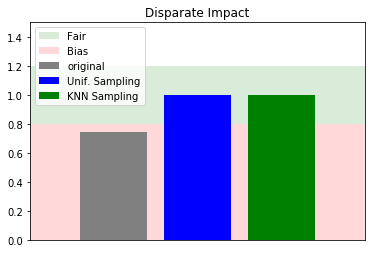

In [44]:
plt.figure()
plt.ylim([0, 1.5])
plt.xlim([-1, 3])
plt.axhspan(0.8, 1.2, facecolor='green', alpha=0.15, label='Fair')
plt.axhspan(0, 0.8, facecolor='red', alpha=0.15, label='Bias')
plt.bar(0, di_pre_orig, align='center', label='original', color='grey')
plt.bar(1, di_pre_us, align='center', label='Unif. Sampling', color='blue')
plt.bar(2, di_pre_us_knn, align='center', label='KNN Sampling', color='green')
plt.xticks([])
plt.title('Disparate Impact')
plt.legend()
plt.show()

Results confirm that the method is working correctly, as we get now values within the fairness range for both metrics.

### Model training on modified data

As we want to check whether we have been able to mitigate the bias or not, we need to compare the results obtained using the original and the transformed data. The classifier should therefore remain the same so as that comparison is not altered. For this reason a random forest classifier is trained again, this time with the data obtained after having applied the bias mitigation techniques.

In [45]:
rfc_transf = RandomForestClassifier(random_state=42, 
                                    max_features= 'auto', 
                                    max_depth = CV_rfc.best_params_['max_depth'], 
                                    n_estimators= 100, 
                                    criterion='gini')

rfc_transf.fit(train_transformed_x, train_transformed_y['SALNETO'])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=50, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [46]:
knn_rfc_transf = RandomForestClassifier(random_state=42, 
                                    max_features= 'auto', 
                                    max_depth = CV_rfc.best_params_['max_depth'], 
                                    n_estimators= 100, 
                                    criterion='gini')

knn_rfc_transf.fit(train_transformed_knn_x, train_transformed_knn_y['SALNETO'])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=50, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [47]:
predicted_salary = rfc_transf.predict(test_x)
predicted_y = pd.DataFrame(predicted_salary)

(acc_us, bal_acc_us) = eval_metrics(test_y['SALNETO'], predicted_salary)

predicted_salary_knn = knn_rfc_transf.predict(test_x)
predicted_y_knn = pd.DataFrame(predicted_salary_knn)

(acc_us_knn, bal_acc_us_knn) = eval_metrics(test_y['SALNETO'], predicted_salary_knn)

print("Random Forest with biased data (n_estimators=%i, max_depth=%i):" % (100, CV_rfc.best_params_['max_depth']))
print("    Accuracy: %s" % acc)
print("    Balanced Accuracy: %s" % bal_acc)

print("Random Forest (n_estimators=%i, max_depth=%i) with Uniform Sampling:" % (100, CV_rfc.best_params_['max_depth']))
print("    Accuracy: %s" % acc_us)
print("    Balanced Accuracy: %s" % bal_acc_us)

print("Random Forest (n_estimators=%i, max_depth=%i) with KNN Sampling:" % (100, CV_rfc.best_params_['max_depth']))
print("    Accuracy: %s" % acc_us_knn)
print("    Balanced Accuracy: %s" % bal_acc_us_knn)

Random Forest with biased data (n_estimators=100, max_depth=50):
    Accuracy: 0.8689460191513059
    Balanced Accuracy: 0.8045029431409887
Random Forest (n_estimators=100, max_depth=50) with Uniform Sampling:
    Accuracy: 0.8633706561925412
    Balanced Accuracy: 0.7950885442655774
Random Forest (n_estimators=100, max_depth=50) with KNN Sampling:
    Accuracy: 0.8637792525323088
    Balanced Accuracy: 0.794654794718876


After retraining the model on the modified dataset we can confirm that the results we get when applying every metric previously defined have improved while the performace of the model has barely decreased ( 0.7% on accuracy and 1.75% on balanced accuracy).

Notice that the test set used is exactly the same as with the unmodified data, that is, we have only modified the training data so the results are directly comparable.

## After-model metrics


In [0]:
test_y['predicted_US'] = predicted_salary
test_y['predicted_knn'] = predicted_salary_knn

In [49]:
spd_us = statistical_parity_difference(test_y, 'SEXO', 6, 1, 'predicted_US')
print(spd_us)

spd_knn = statistical_parity_difference(test_y, 'SEXO', 6, 1, 'predicted_knn')
print(spd_knn)

-0.1656587378709885
-0.15887263831446796


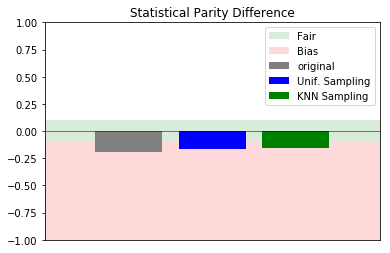

In [50]:
import matplotlib.pyplot as plt
plt.figure()
plt.ylim([-1, 1])
plt.xlim([-1, 3])
plt.axhspan(-0.1, 0.1, facecolor='green', alpha=0.15, label='Fair')
plt.axhspan(-1, -0.1, facecolor='red', alpha=0.15, label='Bias')
plt.bar(0, spd_orig, align='center', label='original', color='grey')
plt.bar(1, spd_us, align='center', label='Unif. Sampling', color='blue')
plt.bar(2, spd_knn, align='center', label='KNN Sampling', color='green')
plt.axhline(y=0, color='black', lw=0.5)
plt.xticks([])
plt.title('Statistical Parity Difference')
plt.legend()
plt.show()

In [51]:
di_us = disparate_impact(test_y, 'SEXO', 6, 1, 'predicted_US')
print(di_us)

di_knn = disparate_impact(test_y, 'SEXO', 6, 1, 'predicted_knn')
print(di_knn)

0.8064881668248368
0.8141544174425943


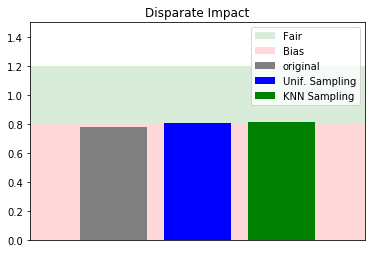

In [52]:
plt.figure()
plt.ylim([0, 1.5])
plt.xlim([-1, 3])
plt.axhspan(0.8, 1.2, facecolor='green', alpha=0.15, label='Fair')
plt.axhspan(0, 0.8, facecolor='red', alpha=0.15, label='Bias')
plt.bar(0, di_orig, align='center', label='original', color='grey')
plt.bar(1, di_us, align='center', label='Unif. Sampling', color='blue')
plt.bar(2, di_knn, align='center', label='KNN Sampling', color='green')
plt.xticks([])
plt.title('Disparate Impact')
plt.legend()
plt.show()

In [53]:
eod_us = equal_opportunity_difference(test_y,'SEXO', 6, 1,'SALNETO', 'predicted_US')
print(eod_us)

eod_knn = equal_opportunity_difference(test_y,'SEXO', 6, 1,'SALNETO', 'predicted_knn')
print(eod_knn)

-0.018091486569857818
-0.013309561094023259


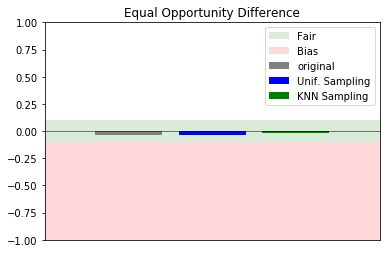

In [54]:
plt.figure()
plt.ylim([-1, 1])
plt.xlim([-1, 3])
plt.axhspan(-0.1, 0.1, facecolor='green', alpha=0.15, label='Fair')
plt.axhspan(-1, -0.1, facecolor='red', alpha=0.15, label='Bias')
plt.bar(0, eod_orig, align='center', label='original', color='grey')
plt.bar(1, eod_orig, align='center', label='Unif. Sampling', color='blue')
plt.bar(2, eod_knn, align='center', label='KNN Sampling', color='green')
plt.axhline(y=0, color='black', lw=0.5)
plt.xticks([])
plt.title('Equal Opportunity Difference')
plt.legend()
plt.show()

In [55]:
aod_us = average_odds_difference(test_y, 'SEXO', 6, 1, 'SALNETO', 'predicted_US')
print(aod_us)

aod_knn = average_odds_difference(test_y, 'SEXO', 6, 1, 'SALNETO', 'predicted_knn')
print(aod_knn)

-0.06422015112029544
-0.05558855885075831


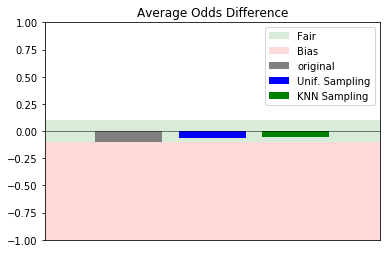

In [56]:
plt.figure()
plt.ylim([-1, 1])
plt.xlim([-1, 3])
plt.axhspan(-0.1, 0.1, facecolor='green', alpha=0.15, label='Fair')
plt.axhspan(-1, -0.1, facecolor='red', alpha=0.15, label='Bias')
plt.bar(0, aod_orig, align='center', label='original', color='grey')
plt.bar(1, aod_us, align='center', label='Unif. Sampling', color='blue')
plt.bar(2, aod_knn, align='center', label='KNN Sampling', color='green')
plt.axhline(y=0, color='black', lw=0.5)
plt.xticks([])
plt.title('Average Odds Difference')
plt.legend()
plt.show()

All four metrics obtain better results after applying the mitigation bias techniques. 2 of them already fell within their fairness ranges, but now one more metric falls within that range and the other one is closer to it than before.

Regarding the KNN Sampling method, we can see the results are slightly better than those obtained with the US Sampling one. This is due to the generation of synthetic data instead of replicating the data we already had.


## Discussion

As we can see from the figures above, we have managed to train a model that has considerably less bias and retains almost the same accuracy. We have replicated the experiment using logistic regression instead of random forest obtaining pretty much the same results, which shows that the bias is learnt regardless of the classifier used.

As a society we have to move towards a less discriminative world and machine learning provides a perfect opportunity for that. Every day more and more decisions are relegated to machines, and we have to be careful with how we teach them just like we are when teaching kids at school. It is in our hands to make the machines taking important decisions concerning people's rights to be fair and guarantee that every one of us is treated fairly. Fortunately, there is an increasing volume of research in this topic and better bias mitigation algorithms are being developed, shining a bright future onto this topic.